# Analyzing Edit Activity of Swiss Cities

In [1]:
%matplotlib inline

from gastrodon import RemoteEndpoint, QName, ttl, URIRef, inline
from wikidata.client import Client
import requests
import json
from io import StringIO
from collections import Counter, defaultdict
import time
import datetime
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Cities
In this section, we get the cities of Switzerland. This is performed by the SPARQL query:

In [ ]:
"""
SELECT ?city ?cityLabel WHERE {
    ?city wdt:P31 wd:Q54935504
    
    SERVICE wikibase:label {
        bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en".
    }
} ORDER BY ?cityLabel
"""

Here, **wdt:p31** corresponds to the predicate **instance of**, and **wd:Q54935504** corresponds to the entity **cities of Switzerland**.

We obtain the label of the entity we get (city) by using the wikibase:label service. Finally, the results are ordered alphabetically.

In [2]:
prefixes = inline("""
   @prefix wd: <http://www.wikidata.org/entity/> .
   @prefix wdt: <http://www.wikidata.org/prop/direct/> .
   @prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
""").graph

endpoint = RemoteEndpoint(
   "http://query.wikidata.org/sparql"
   ,prefixes=prefixes
)

locs_in_switzerland = endpoint.select("""
SELECT ?city ?cityLabel WHERE {
  ?city wdt:P31 wd:Q54935504
        
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
} ORDER BY ?cityLabel""")

In [3]:
locs_in_switzerland.tail(25)

# TODO: combine SPARQL and visualizations

,city,cityLabel
136,wd:Q68978,Thun
137,wd:Q68201,Thônex
138,wd:Q69109,Urdorf
139,wd:Q64032,Uster
140,wd:Q64171,Uzwil
141,wd:Q63922,Vernier
142,wd:Q63979,Versoix
143,wd:Q68160,Vevey
144,wd:Q69760,Villars-sur-Glâne
145,wd:Q64147,Visp


Here, we manually write the entity IDs of some of the cities of Switzerland.

In [4]:
bern = 'Q70'
geneva = 'Q71'
zurich = 'Q72'
basel = 'Q78'
canton_zurich = 'Q11943'

client = Client()
print(client.get(zurich, load=True))
print(client.get(canton_zurich, load=True))

<wikidata.entity.Entity Q72 'Zürich'>
<wikidata.entity.Entity Q11943 'canton of Zürich'>


## Get the Complete Edit Activity

In [5]:
def edit_hist(item):
    """
    This function returns the complete edit history of the entity with the given entity ID.
    
    Parameters
    ----------
    item: str
        Q ID of the entity. For Zurich, this corresponds to Q72.
        
    Returns
    -------
    edit_hist : pandas.DataFrame
        Complete edit history of the given entity. The returned dataframe has the following
        columns: UserID, User, Timestamp, Size, Comment
    """
    fields = ['timestamp', 'user', 'userid', 'comment', 'size']
    field_str = '%7C'.join(fields)
    limit = '500'
    query_template = 'https://www.wikidata.org/w/api.php?action=query&format=json&prop=revisions&titles={item}&rvprop={fields}&rvslots=main&rvlimit={limit}'
    query = query_template.format(
        item=item, fields=field_str, limit=limit)

    curr_hist_dict = requests.get(query).json()

    res_str = 'UserID,User,Timestamp,Size,Comment\n'

    while True:
        for page in curr_hist_dict['query']['pages'].values():
            for revision in page['revisions']:
                res_str += str(revision['userid']) + ','
                res_str += revision['user'] + ','
                res_str += revision['timestamp'] + ','
                res_str += str(revision['size']) + ','
                
                raw_comment = revision['comment']
                escaped_comment = raw_comment.translate(str.maketrans({',' : '\\,'}))
                res_str += escaped_comment + '\n'

        try:
            continue_field = curr_hist_dict['continue']['rvcontinue']
            new_query = query + '&rvcontinue=' + continue_field
            curr_hist_dict = requests.get(new_query).json()
        except KeyError:
            break
            
    return pd.read_csv(StringIO(res_str), quoting=3, escapechar='\\')

## Get Visit History For the Last 60 Days

In [6]:
def visit_hist(item):
    """
    Get the visit history of the entity with the given entity ID for the last 60 days.
    
    Parameters
    ----------
    item: str
        Q ID of the entity. For Zurich, this corresponds to Q72.
        
    Returns
    -------
    visit_hist : pandas.DataFrame
        Complete visit history of the given entity. The returned dataframe has the following
        columns: Date, VisitCount
    """
    query_template = 'https://www.wikidata.org/w/api.php?action=query&format=json&prop=pageviews&titles={item}'
    query = query_template.format(item=item)

    visit_dict = requests.get(query).json()

    res_str = 'Date,VisitCount\n'
    
    for page in visit_dict['query']['pages'].values():
        for date, count in page['pageviews'].items():
            if count is None:
                count = 0
            res_str += date + ',' + str(count) + '\n'
            
    return pd.read_csv(StringIO(res_str))

# Analysis

In this section, we analyze the edit and visit history data.

In [7]:
item_to_analyze = zurich
edit_df = edit_hist(item_to_analyze)
visit_df = visit_hist(item_to_analyze)

# Transform the timestamp string columns to python timestamp objects
# for easier time manipulations and filtering
edit_df['Timestamp'] = edit_df['Timestamp'].apply(lambda s: datetime.datetime.strptime(s, "%Y-%m-%dT%H:%M:%SZ").timetuple())
visit_df['Date'] = visit_df['Date'].apply(lambda s: datetime.datetime.strptime(s, "%Y-%m-%d").timetuple())

## Number of Edits per Year
We count the number of edits per each year since the beginning of the dataset and plot the results.

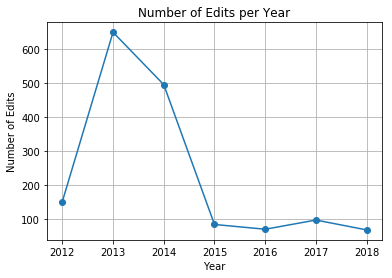

In [8]:
edit_df_yearly = edit_df['Timestamp'].copy()
edit_df_yearly = edit_df_yearly.transform(lambda t: t.tm_year)

yearly_counts = Counter(edit_df_yearly.values)
fig = plt.figure()
plt.plot(yearly_counts.keys(), yearly_counts.values(), marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Edits')
plt.grid()
plt.title('Number of Edits per Year');
fig.savefig('num_edits.png')

## Number of Edits per Month of Year
We count the number of edits on each month for a given year and plot the results.

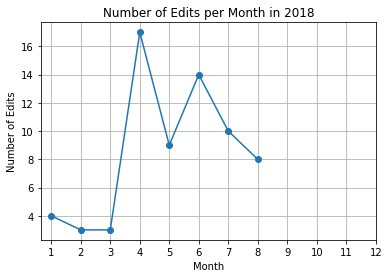

In [9]:
year = 2018

monthly_counts = defaultdict(int)
for row in edit_df['Timestamp']:
    if row.tm_year == year:
        monthly_counts[row.tm_mon] += 1

plt.plot(monthly_counts.keys(), monthly_counts.values(), marker='o')
plt.xticks(np.arange(1, 13))
plt.xlabel('Month')
plt.ylabel('Number of Edits')
plt.grid()
plt.title('Number of Edits per Month in {}'.format(year));

## Size Change Frequency of Edits
We group edits based on how much content was added/removed and plot a histogram of the results.

In [10]:
content_size = edit_df['Size'].values
diff = -(content_size[1:] - content_size[:-1])
new_column = np.append(diff, edit_df['Size'].iloc[-1])
edit_size_diffs = edit_df.copy()
edit_size_diffs['Size'] = pd.Series(new_column)

In [11]:
intervals = np.arange(0, 1001, 50).astype(float)
intervals = np.insert(intervals, 0, -np.inf)
intervals = np.append(intervals, np.inf)
counts = np.zeros(len(intervals) - 1, dtype=np.int64)

In [12]:
for (idx,), lo in np.ndenumerate(intervals[:-1]):
    hi = intervals[idx + 1]
    cnt = len(edit_size_diffs[(edit_size_diffs['Size'] >= lo) & (edit_size_diffs['Size'] < hi)])
    counts[idx] = cnt

In [13]:
labels = []
for point in intervals[1:-1]:
    labels.append('< {}'.format(int(point)))
labels.append('< inf')

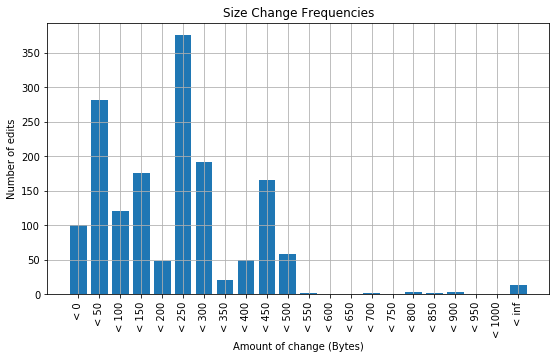

In [14]:
indices = np.arange(len(counts))


fig = plt.figure(figsize=(9, 5))
plt.bar(indices, counts, align='center')
plt.xlabel('Amount of change (Bytes)')
plt.ylabel('Number of edits')
plt.title('Size Change Frequencies')
plt.grid()
plt.xticks(indices, labels, rotation=90);
fig.savefig('size_freq.png')

## Content Size vs Time
We plot the size of the content against the number of edits.

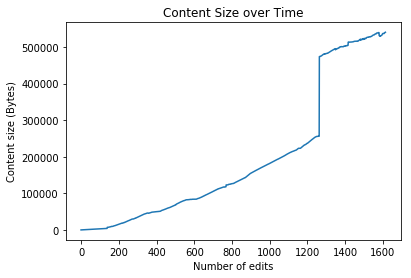

In [15]:
size = edit_df['Size'].values
size = size[::-1]
plt.plot(size)
plt.xlabel('Number of edits')
plt.ylabel('Content size (Bytes)')
plt.title('Content Size over Time');

## Views per Last 60 Days
We plot the number of views over the last 60 days.

**Note**: Unfortunately, wikidata API does not allow getting the visit count data for more than the last 60 days.

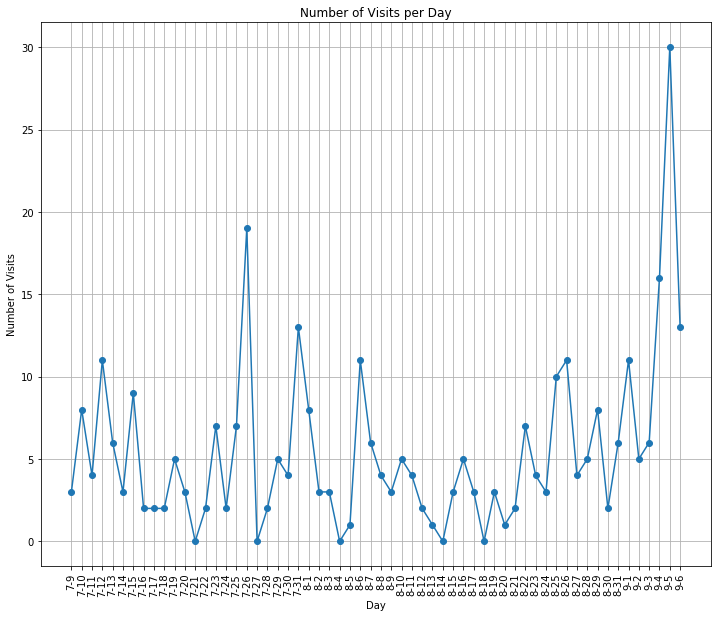

In [16]:
keys = []
vals = []

for _, row in visit_df.iterrows():
    keys.append('{}-{}'.format(row['Date'].tm_mon, row['Date'].tm_mday))
    vals.append(row['VisitCount'])

plt.figure(figsize=(12, 10))
num_days = 60
plt.plot(vals[:num_days], marker='o')
plt.xlabel('Day')
plt.xticks(np.arange(num_days), keys[:num_days], rotation=90)
plt.grid()
plt.ylabel('Number of Visits')
plt.title('Number of Visits per Day');